### Load file here

In [12]:
dat = pd.read_csv("../Data/cleaned_data.csv")

.

In [13]:
dat = dat.loc[:, "Access":]

In [14]:
dat

,Access,DMA,Date Aired,Estimate,GRP,Impression,Impression (000),Impressions,Length,Market,Media,Spot Cost,Spot Type,Station ID,Time Aired,DOW,daypart
0,30GD,900,2018-12-31,Q119,0.000,NaN,0.0,NaN,30,National Network,TV,56.0,INV,37,00:06:00,Monday,Late Night
1,30TN,900,2018-12-31,Q119,0.000,NaN,0.0,NaN,30,Cable,TV,56.0,INV,202,00:07:00,Monday,Late Night
2,30PM,900,2018-12-31,Q119,0.016,NaN,27.2,NaN,30,Cable,TV,142.4,INV,253,00:09:00,Monday,Late Night
3,30PM,900,2018-12-31,Q119,0.128,NaN,158.4,NaN,30,Cable,TV,64.0,INV,340,00:09:00,Monday,Late Night
4,30GD,900,2018-12-31,Q119,0.000,NaN,0.0,NaN,30,Cable,TV,56.0,INV,168,00:10:00,Monday,Late Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683324,30GD,900,2019-07-28,Q319,0.000,NaN,NaN,0.0,30,Cable,TV,80.0,INV,50,23:53:00,Sunday,Late Fringe
683325,30GD,900,2019-07-28,Q319,0.000,NaN,NaN,0.0,30,Cable,TV,48.0,INV,196,23:54:00,Sunday,Late Fringe
683326,30PT,900,2019-07-28,Q319,0.000,NaN,NaN,0.0,30,Cable,TV,48.0,INV,313,23:55:00,Sunday,Late Fringe
683327,30PM,900,2019-07-28,Q319,0.000,NaN,NaN,0.0,30,Cable,TV,80.0,INV,39,23:56:00,Sunday,Late Fringe


In [15]:
dat.describe()

,GRP,Impression,Impression (000),Impressions,Spot Cost,Station ID
count,683329.000000,137411.000000,42107.000000,503811.000000,683329.000000,683329.000000
mean,0.003449,4.404759,4.063704,3.996711,81.780412,199.087582
std,0.016554,18.869537,21.281177,19.569565,108.355123,110.998866
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,48.000000,92.000000
50%,0.000000,0.000000,0.000000,0.000000,56.000000,219.000000
75%,0.000000,0.000000,0.000000,0.000000,96.000000,296.000000
max,0.864000,668.800000,712.000000,1046.400000,5208.000000,379.000000


In [16]:
dat.dtypes

Access               object
DMA                  object
Date Aired           object
Estimate             object
GRP                 float64
Impression          float64
Impression (000)    float64
Impressions         float64
Length               object
Market               object
Media                object
Spot Cost           float64
Spot Type            object
Station ID            int64
Time Aired           object
DOW                  object
daypart              object
dtype: object

In [17]:
dat["Date Aired"] = pd.to_datetime(dat["Date Aired"], format="%Y-%m-%d")
dat["Time Aired"] = pd.to_datetime(dat["Time Aired"], format="%H:%M:%S").dt.time

In [18]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

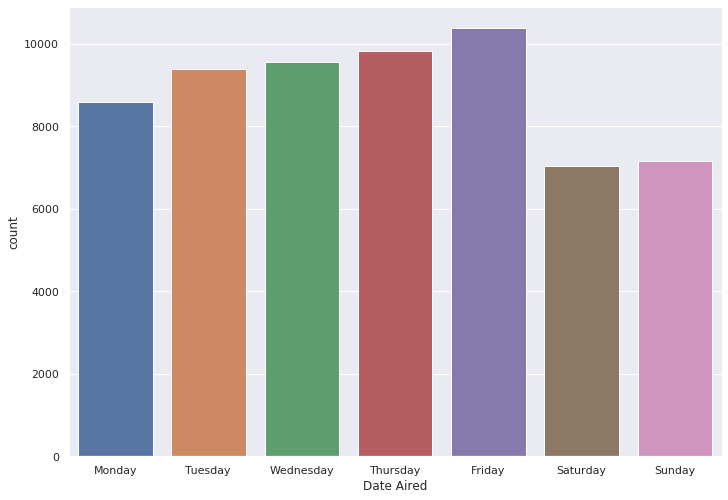

In [19]:
ax = sns.countplot(x=training["Date Aired"].dt.day_name(), data=dat)

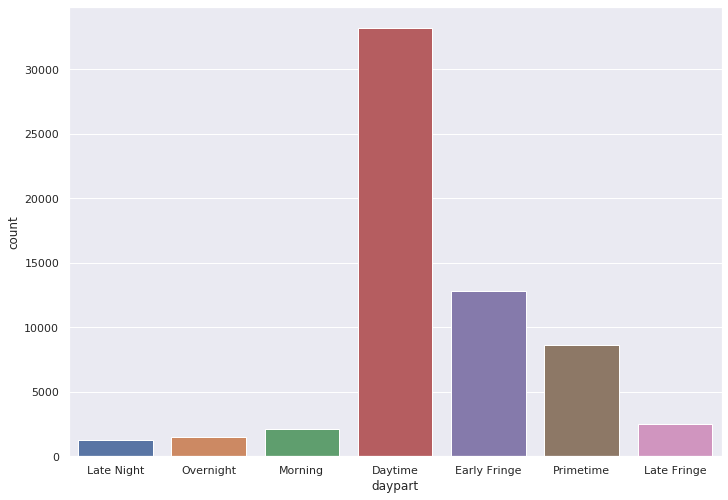

In [20]:
ax = sns.countplot(x=training["daypart"], data=dat)

In [ ]:
fig, ax = plt.subplots(1, 2)
sns.regplot(x=training["Spot Cost"], y=training["GRP"], data=training, ax=ax[0])
sns.regplot(x=training["Spot Cost"], y=training["Impressions"], data=training, ax=ax[1])

In [ ]:
sns.boxplot(x=training["Market"], y=training["GRP"], data=training, palette="rainbow")

In [ ]:
box = sns.boxplot(x=training["Station ID"], y=training["GRP"], data=training, palette="rainbow")
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

## Model Training

### Linear Regression

In [80]:
outliers = pd.read_pickle('outlier_stations.pickle')

outlier_stations = list(outliers.index.get_level_values('Station ID'))[0:12]
outlier_stations

[216, 184, 352, 311, 200, 10, 15, 192, 224, 280, 252, 72]

In [81]:
dat = pd.concat([dat, pd.get_dummies(dat["Estimate"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Access"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"], drop_first=True)], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"], drop_first=True)], axis=1)

dat['is_outlier'] = np.where(np.isin(dat['Station ID'], outlier_stations), 1, 0)
dat.columns

KeyError: 'Station ID'

In [ ]:
dat = dat.rename(columns=lambda x: x.strip().replace(' ', '_'))
dat.columns

In [ ]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0))]
training = dat[dat.GRP > 0.0]

labels = [
        "Length",
        "Spot_Cost",
        "Q219",
        "Q319",
        "Q419",
        "15GD",
        "15PN",
        "30BP",
        "30DE",
        "30DP",
        "30GD",
        "30GX",
        "30PL",
        "30PM",
        "30PT",
        "30SR",
        "30TN",
        "30VE",
        "SV15",
        "DirecTV",
        "Dish_Network",
        "National_Network",
        "Over-the-top_content",
        "Sunday",
        "Thursday",
        "Tuesday",
        "Wednesday",
        "Early_Fringe",
        "Late_Fringe",
        "Late_Night",
        "Morning",
        "Overnight",
        "Primetime",
        "is_outlier"
    ]

X = training.loc[:,labels]
y = training.loc[:, "Impressions"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
lr = sm.OLS(y_train, X_train).fit()

lr_preds = lr.predict(X_test)

lr_mse = MSE(y_test, lr_preds)
lr_mse

In [78]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GRP   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     849.0
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:05:59   Log-Likelihood:                 86108.
No. Observations:               42430   AIC:                        -1.722e+05
Df Residuals:                   42397   BIC:                        -1.719e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Length                   0.0017      0.000     11.865      0.000       0.001       0.002
Spot_Cost              6.19e-05   6.64e-07     93.234      0.000    6.06e-05    6.32e-05
Q219                     0.0003      0.000      1.130      0.258      -0.000       0.001
Q219                     0.0003      0.000      1.130      0.258      -0.000       0.001
Q319                     0.0015      0.000      5.484      0.000       0.001       0.002
Q319                     0.0015      0.000      5.484      0.000       0.001       0.002
Q419                    -0.0016      0.000     -5.656      0.000      -0.002      -0.001
Q419                    -0.0016      0.000     -5.656      0.000      -0.002      -0.001
15GD                    -0.0006      0.001     -0.476      0.634      -0.003       0.002
15GD                    -0.0006      0.001     -0.476      0.634      -0.003       0.002
15PN                     0.0022      0.001      1.510      0.131      -0.001       0.005
15PN                     0.0022      0.001      1.510      0.131      -0.001       0.005
30BP                    -0.0207      0.002     -9.255      0.000      -0.025      -0.016
30BP                    -0.0207      0.002     -9.255      0.000      -0.025      -0.016
30DE                    -0.0151      0.003     -5.183      0.000      -0.021      -0.009
30DE                    -0.0151      0.003     -5.183      0.000      -0.021      -0.009
30DP                    -0.0098      0.002     -4.478      0.000      -0.014      -0.006
30DP                    -0.0098      0.002     -4.478      0.000      -0.014      -0.006
30GD                    -0.0175      0.002     -8.185      0.000      -0.022      -0.013
30GD                    -0.0175      0.002     -8.185      0.000      -0.022      -0.013
30GX                    -0.0149      0.002     -6.943      0.000      -0.019      -0.011
30GX                    -0.0149      0.002     -6.943      0.000      -0.019      -0.011
30PL                    -0.0149      0.002     -6.144      0.000      -0.020      -0.010
30PL                    -0.0149      0.002     -6.144      0.000      -0.020      -0.010
30PM                    -0.0141      0.002     -6.465      0.000      -0.018      -0.010
30PM                    -0.0141      0.002     -6.465      0.000      -0.018      -0.010
30PT                    -0.0166      0.002     -7.799      0.000      -0.021      -0.012
30PT                    -0.0166      0.002     -7.799      0.000      -0.021      -0.012
30SR                    -0.0088      0.002     -3.958      0.000      -0.013      -0.004
30SR                    -0.0088      0.002     -3.958      0.000      -0.013      -0.004
30TN                    -0.0171      0.003     -6.490      0.000      -0.022      -0.012
30TN                    -0.0171      0.003     -6.490    

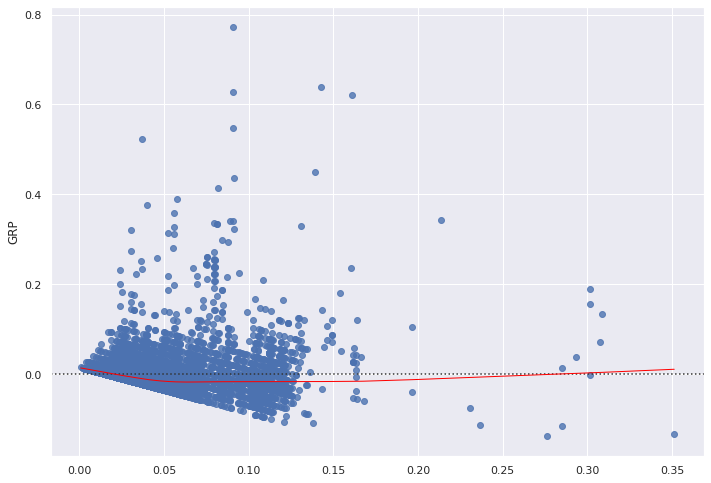

In [39]:
sns.residplot(
    lr_preds,
    y_test,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 1},
)

Text(0.5, 1.0, 'Normal Q-Q Plot')

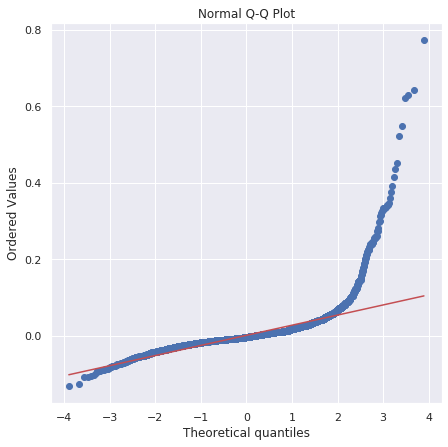

In [40]:
residuals = y_test - lr_preds
residuals

plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

In [ ]:
print(MSE(lr_preds, y_train))

### XGBoost Regressor

In [ ]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

In [ ]:
xgb_preds = xgb.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_preds)

In [ ]:
sns.residplot(
    xgb_preds.reshape(-1),
    y_test,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 1},
)

In [ ]:
residuals = y_test - xgb_preds.reshape(-1)
residuals

plt.figure(figsize=(7, 7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

### Outlier Stations

In [ ]:
dat['month'] = pd.DatetimeIndex(dat['Date Aired']).month
dat['month'] = dat['month'].apply(lambda x: calendar.month_name[x])

#### Outliers by Impressions

In [ ]:
station_averages = dat.groupby(['month', 'Station ID']).mean().reindex(level=1)
monthly_averages = dat.groupby('month').mean().iloc[:, :-1]

In [ ]:
total_averages = station_averages.join(monthly_averages,
                                       on='month', rsuffix='_monthly_averages')

#### Example 1: Find outlier stations in January using January average for Impressions

In [ ]:
january = total_averages.iloc[total_averages.index.get_level_values('month')=='January']
january = january[january['Impressions'].notnull() & january['Impressions']>0]
january['outliers'] = np.where(january['Impressions'] < 2*january['Impressions'].mean(), False, True)
box = sns.barplot(x=january.index.get_level_values('Station ID'), y=january['Impressions'], 
                  data=january, palette=sns.color_palette(), hue='outliers')
line = box.axhline(2*january['Impressions'].mean())
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

#### Example 2: Using GRP

In [ ]:
january['outliers_grp'] = np.where(january['GRP'] < 2*january['GRP'].mean(), False, True)
box = sns.barplot(x=january.index.get_level_values('Station ID'), y=january['GRP'], 
                  data=january, palette=sns.color_palette(), hue='outliers_grp')
line = box.axhline(2*january['GRP'].mean())
box.set_xticklabels(box.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
january[(january.outliers == True) & (january.outliers_grp == True)]